In [ ]:
# Import necessary libraries
from copy import deepcopy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

In [ ]:
import numpy as np
import sys
from copy import deepcopy
from pprint import pprint

from scipy.fftpack import fft, ifft, fftfreq
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc;rc('text', usetex = False)
#rc('text',usetex=True)

import os


In [ ]:
#do analysis of velocity_series
def do_analysis(velocity_series):
    #input velocity_series is a dictionary either for the space or time domain
    #input: velocity_series['domain'] = 'space', velocity_series['dx'], velocity_series['y']
    #input: velocity_series['domain'] = 'time',  velocity_series['dt'], velocity_series['y']

    velocity_series['n']                        = len(velocity_series['y'])
    velocity_series['i']                        = np.arange(velocity_series['n'])

    if (np.sum(np.isnan(velocity_series['y']) | np.isinf(velocity_series['y'])) > 0):
        print("\n\nWARNING: your velocity_series contains nans and/or infs!\n\n")

    if velocity_series['domain'] == 'space':
        velocity_series['x']                    = velocity_series['i'] * velocity_series['dx']
        velocity_series['tau']                  = fftfreq(velocity_series['n']) * 1. * velocity_series['n'] * velocity_series['dx']
        velocity_series['d']                    = velocity_series['dx']
        
    if velocity_series['domain'] == 'time':
        velocity_series['t']                    = velocity_series['i'] * velocity_series['dt']
        velocity_series['tau']                  = fftfreq(velocity_series['n']) * 1. * velocity_series['n'] * velocity_series['dt']
        velocity_series['d']                    = velocity_series['dt']
        
    velocity_series['freq']                     = 2. * np.pi * fftfreq(velocity_series['n'], velocity_series['d'])
    velocity_series['freqsort']                 = np.argsort(velocity_series['freq'])
    velocity_series['freqsort+']                = np.compress(velocity_series['freq'][velocity_series['freqsort']] > 0., velocity_series['freqsort'])

    velocity_series['freqmin']                  = np.min(velocity_series['freq'][velocity_series['freqsort+']])
    velocity_series['freqmax']                  = np.max(velocity_series['freq'][velocity_series['freqsort+']])

    #analysis
    velocity_series['mu']                       = np.average(velocity_series['y'])
    velocity_series['std']                      = np.std(velocity_series['y'])
    velocity_series['var']                      = np.var(velocity_series['y'])

    velocity_series['nonperiodic_d2']           = struct_function(velocity_series['y'], 2, False)
    velocity_series['nonperiodic_d3']           = struct_function(velocity_series['y'], 3, False)
    velocity_series['nonperiodic_autocov']      = autocovariance(velocity_series['y'], False)
    velocity_series['nonperiodic_pow']          = power(velocity_series['y'], False)

    velocity_series['periodic_d2']              = struct_function(velocity_series['y'], 2, True)
    velocity_series['periodic_d3']              = struct_function(velocity_series['y'], 3, True)
    velocity_series['periodic_autocov']         = autocovariance(velocity_series['y'], True)
    velocity_series['periodic_fft'],           \
    velocity_series['periodic_phase'],         \
    velocity_series['periodic_pow']            = power(velocity_series['y'], True)

    return True

In [ ]:
#add Kolmogorov constants to a dictionary
#kolmogorov_constant_power  : Kolmogorov constant for the power spectrum
#kolmogorov_constant_struc2 : Kolmogorov constant for the second order structure function
#kolmogorov_constant_struc3 : Kolmogorov constant for the third order structure function
def kolmogorov_constants(dct, choice):
    C = 1.5

    q           = 2./3.                                                 #~0.66
    C1_div_C2   = (1. / np.pi) * gamma(1.+q) * np.sin(np.pi * q / 2.)   #~0.25
    C2_div_C1   = 1. / C1_div_C2                                        #~4.

    if choice=='longitudinal':        
        dct['kolmogorov_constant_power']     = (18./55.) * C                             #0.49
        dct['kolmogorov_constant_struc2']    = C2_div_C1 * (18./55.) * C                 
        dct['kolmogorov_constant_struc3']    = -4./5.
    elif choice=='transverse':
        dct['kolmogorov_constant_power']     = (4./3.) * (18./55.) * C                   #0.65
        dct['kolmogorov_constant_struc2']    = (4./3.) * C2_div_C1 *  (18./55.) * C
        dct['kolmogorov_constant_struc3']    = np.nan
    elif choice=='full':
        dct['kolmogorov_constant_power']     = C
        dct['kolmogorov_constant_struc2']    = C2_div_C1 * dct['kolmogorov_constant_power']
        dct['kolmogorov_constant_struc3']    = np.nan                                   
    return True

In [ ]:
#add Kolmogorov constants for a (radar / lidar) line of sight to a dictionary
def kolmogorov_constants_los(dct, azimuthrad, azimuth0rad, elevationrad):
    delta_azimuthrad = azimuthrad - azimuth0rad
    
    kc_trans = {}; kc_longi = {}
    kolmogorov_constants(kc_trans, 'transverse')
    kolmogorov_constants(kc_longi, 'longitudinal')

    dct['kolmogorov_constant_power']     = \
                            ((np.cos(elevationrad) * np.cos(delta_azimuthrad))**2.) * kc_longi['kolmogorov_constant_power'] \
                            + ((np.cos(elevationrad) * np.sin(delta_azimuthrad))**2.) * kc_trans['kolmogorov_constant_power'] \
                            + (np.sin(elevationrad)**2.) * kc_trans['kolmogorov_constant_power']
    dct['kolmogorov_constant_struc2']    = \
                            ((np.cos(elevationrad) * np.cos(delta_azimuthrad))**2.) * kc_longi['kolmogorov_constant_struc2'] \
                            + ((np.cos(elevationrad) * np.sin(delta_azimuthrad))**2.) * kc_trans['kolmogorov_constant_struc2'] \
                            + (np.sin(elevationrad)**2.) * kc_trans['kolmogorov_constant_struc2']
    dct['kolmogorov_constant_struc3']    = -4./5.
    return True

In [ ]:
#One EDR is retrieved for the sequence of velocities
def do_edr_retrievals(dct):
    do_analysis(dct)       #do analysis first
    
    def minimalzero(x):
        if x < 0:
            return 1.e-20
        else:
            return x
    
    for key_str in ['periodic', 'nonperiodic']:          
        #edr via variance method
        res   = retr_edr_via_variance(dct, key_str)
        dct[key_str+'_variancemethod_edr']          = res['edr']
        dct[key_str+'_variancemethod_edrerr']       = res['edr.err']
        dct[key_str+'_variancemethod_edr+']         = (res['edr'] ** (1./3.) + res['edr.err'])**3.
        dct[key_str+'_variancemethod_edr-']         = minimalzero((res['edr'] ** (1./3.) - res['edr.err'])**3.)
        dct[key_str+'_variancemethod_edr++']        = (res['edr'] ** (1./3.) + 2. * res['edr.err'])**3.
        dct[key_str+'_variancemethod_edr--']        = minimalzero((res['edr'] ** (1./3.) - 2. * res['edr.err'])**3. )

        #edr via power spectrum method
        res = retr_edr_via_power_spectrum(dct,key_str)
        dct[key_str+'_powerspectrum_edr']           = res['edr']
        dct[key_str+'_powerspectrum_edrerr']        = res['edr.err']
        dct[key_str+'_powerspectrum_edr+']          = (res['edr'] ** (1./3.) + res['edr.err'])**3.
        dct[key_str+'_powerspectrum_edr-']          = minimalzero( (res['edr'] ** (1./3.) - res['edr.err'])**3.        )
        dct[key_str+'_powerspectrum_edr++']         = (res['edr'] ** (1./3.) + 2. * res['edr.err'])**3.
        dct[key_str+'_powerspectrum_edr--']         = minimalzero((res['edr'] ** (1./3.) - 2. * res['edr.err'])**3.       )
        dct[key_str+'_powerspectrum_lstedr']        = res['lst_edr']
        dct[key_str+'_powerspectrum_lstfreq']       = res['lst_freq']
        dct[key_str+'_powerspectrum_lstfreqmin']    = res['lst_freqmin']
        dct[key_str+'_powerspectrum_lstfreqmax']    = res['lst_freqmax']

        #edr via second order structure function
        res = retr_edr_via_2nd_order(dct,key_str)
        dct[key_str+'_2ndorder_edr']                = res['edr']
        dct[key_str+'_2ndorder_edrerr']             = res['edr.err']
        dct[key_str+'_2ndorder_edr+']               = (res['edr'] ** (1./3.) + res['edr.err'])**3.
        dct[key_str+'_2ndorder_edr-']               = minimalzero((res['edr'] ** (1./3.) - res['edr.err'])**3.)
        dct[key_str+'_2ndorder_edr++']              = (res['edr'] ** (1./3.) + 2. * res['edr.err'])**3.
        dct[key_str+'_2ndorder_edr--']              = minimalzero( (res['edr'] ** (1./3.) - 2. * res['edr.err'])**3.)
        dct[key_str+'_2ndorder_lstedr']             = res['lst_edr']

        #edr via third order structure function        
        res = retr_edr_via_3rd_order(dct,key_str)
        dct[key_str+'_3rdorder_edr']                = res['edr']
        dct[key_str+'_3rdorder_edrerr']             = res['edr.err']
        dct[key_str+'_3rdorder_edr+']               = (np.sign(res['edr']) * (np.abs(res['edr']) ** (1./3.)) + res['edr.err'])**3.
        dct[key_str+'_3rdorder_edr-']               = (np.sign(res['edr']) * (np.abs(res['edr']) ** (1./3.)) - res['edr.err'])**3.
        dct[key_str+'_3rdorder_edr++']              = (np.sign(res['edr']) * (np.abs(res['edr']) ** (1./3.)) + 2. * res['edr.err'])**3.
        dct[key_str+'_3rdorder_edr--']              = (np.sign(res['edr']) * (np.abs(res['edr']) ** (1./3.)) - 2. * res['edr.err'])**3.
        dct[key_str+'_3rdorder_lstedr']             = res['lst_edr']

        #Calculation according to Siebert et al. (2006)
        #Siebert, H., Lehmann, K., & Wendisch, M. (2006). Observations of Small-Scale Turbulence and Energy Dissipation Rates in the Cloudy Boundary Layer. Journal of the Atmospheric Sciences, 63(5), 1451-1466. http://doi.org/10.1175/JAS3687.1
        nu = 1.5e-5 #kinematic viscosity
        dct[key_str+'_powerspectrum_taylorreynolds'] = (dct['std'] ** 2. ) * np.sqrt(15. / (nu * dct[key_str+'_powerspectrum_edr']))      
    return True

In [ ]:
f_even = lambda x: x % 2 == 0
#help function
def taulist(n):
    if f_even(n):
        lst1 = 1+np.arange(n/2-1)
        lst2 = np.hstack((0,lst1, -n/2,-lst1[::-1]))
    else:
        lst1 = 1+np.arange((n-1)/2)
        lst2 = np.hstack((0,lst1,-lst1[::-1]))
    return np.array(lst2, dtype=int)

#calculate autocovariance of x
def autocovariance(x, periodic=False):
    n = len(x)
    x_auto = np.zeros(n) + np.nan
    if periodic:
        #assume that sequence x is periodic
        for i in taulist(n):   #0, 1, 2, 3, ... -3, -2, -1
            a = x[:]
            b = np.hstack(( x[i:], x[0:i] ))
            x_auto[i] = np.cov(a,b, bias=1)[0,1]
    else:
        #assume that sequence x is non-periodic
        for i in taulist(n):   #0, 1, 2, 3, ... -3, -2, -1
            if i > 0:
                a = x[:-i]
                b = x[i:]
            if i <= 0:
                a = x[-i:]
                b = x[0:n+i]
            x_auto[i] = np.cov(a,b, bias=1)[0,1]        
    return x_auto

#calculate power density spectrum
def power(x, periodic=False):
    if periodic:
        o_fft   = fft(x)
        o_phase = np.angle(o_fft)
        o_pow   = np.abs(o_fft /len(x))**2.
        return o_fft, o_phase, o_pow
    else:
        ac      = autocovariance(x, False)
        mu      = np.average(x)
        o_acfft = fft((ac + mu**2.) / len(x))
        o_pow   = np.real(o_acfft)
        o_pow   = np.abs(o_pow)
        return o_pow

#calculate structure function of x
def struct_function(x, order=2, periodic=False):
    n = len(x)
    x_struc = np.zeros(n) + np.nan

    if periodic:
        #assume that sequence x is periodic
        for i in taulist(n):   #0, 1, 2, 3, ... -3, -2, -1
            a = x[:]
            b = np.hstack(( x[i:], x[0:i] ))
            lst1 = (np.sign(a-b)**order) *(np.abs(a-b)**(order))
            x_struc[i] = np.average(lst1)
    else:
        #assume that sequence x is non-periodic
        for i in taulist(n):   #0, 1, 2, 3, ... -3, -2, -1
            if i > 0:
                a = x[:-int(i)]
                b = x[int(i):]
            if i <= 0:
                a = x[-int(i):]    
                b = x[:int(n+i)]     
            #print('a:')
            #print(a)
            #print('b:')
            #print(b)
            lst1 = (np.sign(a-b)**order) *(np.abs(a-b)**(order))
            x_struc[int(i)] = np.average(lst1)
    return x_struc

#make fft coefficients real
def make_fft_coef_real(fft_coef_in):
    fft_coef = deepcopy(fft_coef_in)
    n = len(fft_coef)
    if f_even(n):
        fft_coef[-1:int(-n/2):-1] = np.conj(fft_coef[1:int(n/2)]) #make signal real for even number
        fft_coef[int(n/2)] = np.abs(fft_coef[int(n/2)])           #for even number            
    else:
        fft_coef[-1:-1-int(n/2):-1] = np.conj(fft_coef[1:int(n/2+1)])   #make signal real for uneven number         
    return fft_coef 


In [ ]:
#EDR via variance
#k      : wavenumber
#dk     : smallest wavenumber
#eps    : eddy dissipation rate
#C      : Kolmogorov universal constant
def retr_edr_via_variance(dct,key_str):
    thisedr     = (((3.0/2.0) * dct['kolmogorov_constant_power'] * \
                        (  ((dct['freqmin'] - 0.5 * dct['freqmin']) ** (-2.0/3.0))  - ((dct['freqmax'] + 0.5 * dct['freqmin']) ** (-2.0/3.0)) ) \
                        ) ** (-3.0/2.0) ) \
                        * (dct['var'] ** (3.0/2.0))

    if dct['domain'] == 'time':
        thisedr *= dct['u0'] ** (-1.0)

    res = {}
    res['edr']      = thisedr
    
    if dct['domain'] == 'time':
        res['edr.err'] = (1./3.) * \
                            (res['edr'] ** (1. / 3.)) \
                            * np.sqrt(((dct['freqmin']/dct['freqmax'])**(4./3.)) + (dct['var'] / (dct['u0'] ** 2.)) + (9. / (2. * (dct['n'] - 1.))))
    else:
        res['edr.err'] = (1./3.) * \
                            (res['edr'] ** (1. / 3.)) \
                            * np.sqrt(((dct['freqmin']/dct['freqmax'])**(4./3.)) +  (9. / (2. * (dct['n'] - 1.))))
    
    return res


#EDR via power spectrum.
#k      : wavenumber
#dk     : smallest wavenumber
#eps    : eddy dissipation rate
#C      : Kolmogorov universal constant
model_edr_via_power_spectrum    = lambda k,eps, dk, C: (3./2.) * C * ( eps ** (2./3.)) * (((k - (0.5 * dk)) ** (-2./3.))    - ((k + (0.5*dk)) ** (-2./3.))  )
model_edr_via_power_spectrum2   = lambda k,eps, dk, C: C * ( eps ** (2./3.)) * k ** (-5./3.)
#model_edr_via_power_spectrum3   = lambda k,eps, dk, C: dk * C * ( eps ** (2./3.)) * k ** (-2./3.)

def retr_edr_via_power_spectrum(dct,key_str):
    fft_pfreq   = dct['freq'][dct['freqsort+']]
    fft_ppow    = dct[key_str+'_pow'][dct['freqsort+']]
    
    nintervals  = 3
    nfreq       = max(1,int(np.ceil((1. * len(fft_ppow)) / nintervals)))        #number of frequencies per interval
    
    j = -1
    res = {}
    res['lst_pow']      = []
    res['lst_freq']     = []
    res['lst_freqmin']  = []
    res['lst_freqmax']  = []
    res['lst_edr']      = []

    for i1 in range(0,len(fft_ppow), nfreq):
        i2 = i1 + nfreq
        
        j+=1
        thispow     = 2.0 * np.sum(fft_ppow[i1:i2]) #2.0 because of only positive frequencies
        thisfreq    = np.average(fft_pfreq[i1:i2])
        thisfreqmin = np.min(fft_pfreq[i1:i2])
        thisfreqmax = np.max(fft_pfreq[i1:i2])
        thisedr     = (((3.0/2.0) * dct['kolmogorov_constant_power'] * \
                        (  ((thisfreqmin - 0.5 * dct['freqmin']) ** (-2.0/3.0))  - ((thisfreqmax + 0.5 * dct['freqmin']) ** (-2.0/3.0)) ) \
                        ) ** (-3.0/2.0) ) \
                        * (thispow ** (3.0/2.0))

        if dct['domain'] == 'time':
            thisedr *= dct['u0'] ** (-1.0)
            
        res['lst_pow'].append(thispow)
        res['lst_freq'].append(thisfreq)
        res['lst_freqmin'].append(thisfreqmin)
        res['lst_freqmax'].append(thisfreqmax)
        res['lst_edr'].append(thisedr)      



    res['edr']      = np.average(np.array(res['lst_edr'])**(1./3.))**3.
    res['edr.err']  = np.std(np.array(res['lst_edr'])**(1./3.))
    
    return res

#2nd order structure function
model_edr_via_2nd_order = lambda s,eps, C: C * ( (eps * s  ) ** (2./3.)) 
f_retr_edr_via_2nd_order = lambda s, d2, C: (1./ s) * ((d2 / C) ** (3./2.))
def retr_edr_via_2nd_order(dct,key_str):
    res = {}

    if dct['domain'] == 'time':
        res['lst_edr']  = f_retr_edr_via_2nd_order(dct['u0'] * dct['tau'][dct['freqsort+']],dct[key_str+'_d2'][dct['freqsort+']], dct['kolmogorov_constant_struc2'])
    else:
        res['lst_edr']  = f_retr_edr_via_2nd_order(dct['tau'][dct['freqsort+']],dct[key_str+'_d2'][dct['freqsort+']], dct['kolmogorov_constant_struc2'])
                
    res['edr']      = np.average(res['lst_edr'][1:]**(1./3.))**3.
    res['edr.err']  = np.std(res['lst_edr'][1:]**(1./3.))
    return res
        
#3rd order structure function
model_edr_via_3rd_order = lambda s,eps, C: C *  eps * s 
f_retr_edr_via_3rd_order = lambda s, d3, C: (1./C) * (d3/ s)
def retr_edr_via_3rd_order(dct,key_str):
    res = {}
    if dct['domain'] == 'time':
        res['lst_edr']  = f_retr_edr_via_3rd_order(dct['u0'] * dct['tau'][dct['freqsort+']],dct[key_str+'_d3'][dct['freqsort+']], dct['kolmogorov_constant_struc3'])
    else:
        res['lst_edr']  = f_retr_edr_via_3rd_order(dct['tau'][dct['freqsort+']],dct[key_str+'_d3'][dct['freqsort+']], dct['kolmogorov_constant_struc3'])
                
    res['lst_edr1/3'] = np.sign(res['lst_edr']) * (np.abs(res['lst_edr']) ** (1./3.))
    res['edr']      = np.average(res['lst_edr1/3'][1:])**3.
    res['edr.err']  = np.std(res['lst_edr1/3'][1:])
    return res



from math import gamma    
from scipy.integrate import dblquad
def white1999_I(a, b, L):    
    def myf(phi, theta):
        return (
            12. * gamma(2./3.) * 
            (np.sin(theta) ** 3.) 
            * ((
            ((b ** 2.) * (np.cos(theta)**2.)) +
            ((a ** 2.) * (np.sin(theta)**2.)) +
            (((L**2.)/12.) * (np.sin(theta)**2.) * (np.cos(phi)**2.))
            )**(1./3.))
        )

    return dblquad(myf, 0, np.pi/2., lambda theta: 0., lambda theta: np.pi/2.)[0]
    



In [ ]:
def makeplots(dct, name='edrlib',
    seperate=False,
    plot_periodic = False,
    plot_nonperiodic = True,
    plot_legend = True,
    plot_errors = False,
    units_in = {}):
        
    fontsize0 = 16
    fontsize1 = 14
    matplotlib.rc('xtick', labelsize=fontsize0) 
    matplotlib.rc('ytick', labelsize=fontsize0) 

    #sorting
    sorting = dct['freqsort+']     

    #non-periodic styles
    st_1        = {'color':'red' , 'alpha':0.7, 'linewidth':3}                                          #non-periodic
    st_1p       = {'color':'black' , 'alpha':0.7, 'marker':'x', 'linestyle':'None', 'markersize':3}     #non-periodic
    st_1p_alt   = {'color':'black' , 'alpha':0.7, 'linewidth':3}                                        #non-periodic
    st_1s       = {'color':'red' , 'alpha':0.7, 'linewidth':3, 'linestyle':'--'}                        #non-periodic
    st_1f       = {'color':'#ffe6e6' , 'alpha':0.7}                                                     #non-periodic
    st_1i       = {'color':'red' , 'alpha':0.7, 'linewidth':3, 'linestyle':'-', 'zorder':10}            #non-periodic

    #periodic styles
    st_2        = {'color':'green'   , 'alpha':0.7, 'linewidth':3}                                      #periodic
    st_2p       = {'color':'black'   , 'alpha':0.7, 'marker':'x', 'linestyle':'None'}                   #periodic
    st_2p_alt   = {'color':'black'   , 'alpha':0.7, 'linewidth':3}                                      #periodic
    st_2s       = {'color':'green'   , 'alpha':0.7, 'linewidth':3, 'linestyle':'--'}                    #periodic
    st_2f       = {'color':'#e6ffe6' , 'alpha':0.7}                                                     #periodic
    st_2i       = {'color':'green'   , 'alpha':0.7, 'linewidth':3, 'linestyle':'-', 'zorder':10}        #periodic

    if not seperate:      
        if plot_periodic:
            plot_lst = ['velocity_series', 'autocovariance', 'd2', 'd3', 'pow', 'phase']
        if plot_nonperiodic:
            plot_lst = ['velocity_series', 'autocovariance', 'd2', 'd3', 'pow']
        nrows = len(plot_lst)
        fig = plt.figure(figsize=(5,5*nrows))

    if seperate:
        plot_lst = ['velocity_series', 'autocovariance', 'd2', 'd3', 'pow', 'd22', 'd32', 'pow2', 'phase']
    
    for plot in plot_lst:
        if seperate:
            fig = plt.figure(figsize=(6,4))
            ax = fig.add_subplot(1,1,1)

        if plot == 'velocity_series':
            #velocity_series
            if not seperate:
                ax = fig.add_subplot(nrows,1,1)
                ax.set_title('velocity series')
            if dct['domain'] == 'time':
                ax.plot(dct['t'], dct['y'])
                ax.set_xlabel('$t$ [s]', fontsize=fontsize0)
            else:
                ax.plot(dct['x'], dct['y'])
                ax.set_xlabel('$x$ [m]', fontsize=fontsize0)
            ax.set_ylabel('$v$ [m s$^{-1}$]', fontsize=fontsize0)
           
        if plot == 'autocovariance':
            #autocovariance
            if not seperate:                
                ax = fig.add_subplot(nrows,1,2)
                ax.set_title('autocovariance')

            if plot_nonperiodic:
                ln1 = ax.plot(dct['tau'][sorting], dct['nonperiodic_autocov'][sorting], label='non-periodic',**st_1)
            if plot_periodic:
                ln2 = ax.plot(dct['tau'][sorting], dct['periodic_autocov'][sorting], label='periodic',**st_2)  

            if dct['domain'] == 'time':
                ax.set_xlabel(r'$t$ [s]', fontsize=fontsize0)
            else:
                ax.set_xlabel(r'$s$ [m]', fontsize=fontsize0)
            ax.set_ylabel(r'$R$ [m$^2$ s$^{-2}$]', fontsize=fontsize0)
            if plot_legend:
                ax.legend(ncol=2, loc='lower left', fontsize=fontsize1)

        if plot == 'd2':
            if not seperate:
                ax = fig.add_subplot(nrows,1,3)
                ax.set_title('$D_{2}$')

            if plot_nonperiodic:
                ax.plot(dct['tau'][sorting], dct['nonperiodic_d2'][sorting], label='$D_2$', **st_1p_alt)
            if plot_periodic:
                ax.plot(dct['tau'][sorting], dct['periodic_d2'][sorting], label='$D_2$ (periodic)', **st_2p_alt)
            
            if dct['domain'] == 'time':
                if plot_nonperiodic:
                    ax.plot(dct['tau'][sorting], model_edr_via_2nd_order(dct['tau'][sorting], dct['u0'] * dct['nonperiodic_2ndorder_edr'], dct['kolmogorov_constant_struc2']), label='fit', **st_1)
                    if plot_errors:
                        ax.plot(dct['tau'][sorting], model_edr_via_2nd_order(dct['tau'][sorting], dct['u0'] * dct['nonperiodic_2ndorder_edr++'], dct['kolmogorov_constant_struc2']), **st_1s)
                        ax.plot(dct['tau'][sorting], model_edr_via_2nd_order(dct['tau'][sorting], dct['u0'] * dct['nonperiodic_2ndorder_edr--'], dct['kolmogorov_constant_struc2']), **st_1s)
                        ax.fill_between(dct['tau'][sorting], model_edr_via_2nd_order(dct['tau'][sorting], dct['u0'] * dct['nonperiodic_2ndorder_edr--'], dct['kolmogorov_constant_struc2']),
                            model_edr_via_2nd_order(dct['tau'][sorting], dct['u0'] * dct['nonperiodic_2ndorder_edr++'], dct['kolmogorov_constant_struc2']), **st_1f)
                
                if plot_periodic:
                    ax.plot(dct['tau'][sorting], model_edr_via_2nd_order(dct['tau'][sorting], dct['u0'] * dct['periodic_2ndorder_edr'], dct['kolmogorov_constant_struc2']), label='fit', **st_2)
                    if plot_errors:
                        ax.plot(dct['tau'][sorting], model_edr_via_2nd_order(dct['tau'][sorting], dct['u0'] * dct['periodic_2ndorder_edr++'], dct['kolmogorov_constant_struc2']), **st_2s)
                        ax.plot(dct['tau'][sorting], model_edr_via_2nd_order(dct['tau'][sorting], dct['u0'] * dct['periodic_2ndorder_edr--'], dct['kolmogorov_constant_struc2']), **st_2s)
                        ax.fill_between(dct['tau'][sorting], model_edr_via_2nd_order(dct['tau'][sorting], dct['u0'] * dct['periodic_2ndorder_edr--'], dct['kolmogorov_constant_struc2']),
                            model_edr_via_2nd_order(dct['tau'][sorting], dct['u0'] * dct['periodic_2ndorder_edr++'], dct['kolmogorov_constant_struc2']), **st_2f)
            else:
                if plot_nonperiodic:
                    ax.plot(dct['tau'][sorting], model_edr_via_2nd_order(dct['tau'][sorting] ,dct['nonperiodic_2ndorder_edr'], dct['kolmogorov_constant_struc2']), label='fit', **st_1)
                    if plot_errors:
                        ax.plot(dct['tau'][sorting], model_edr_via_2nd_order(dct['tau'][sorting] ,dct['nonperiodic_2ndorder_edr++'], dct['kolmogorov_constant_struc2']), **st_1s)
                        ax.plot(dct['tau'][sorting], model_edr_via_2nd_order(dct['tau'][sorting] ,dct['nonperiodic_2ndorder_edr--'], dct['kolmogorov_constant_struc2']), **st_1s)
                        ax.fill_between(dct['tau'][sorting], model_edr_via_2nd_order(dct['tau'][sorting], dct['nonperiodic_2ndorder_edr--'], dct['kolmogorov_constant_struc2']),
                            model_edr_via_2nd_order(dct['tau'][sorting], dct['nonperiodic_2ndorder_edr++'], dct['kolmogorov_constant_struc2']), **st_1f)                
                if plot_periodic:
                    ax.plot(dct['tau'][sorting], model_edr_via_2nd_order(dct['tau'][sorting] ,dct['periodic_2ndorder_edr'], dct['kolmogorov_constant_struc2']), label='fit', **st_2)
                    if plot_errors:
                        ax.plot(dct['tau'][sorting], model_edr_via_2nd_order(dct['tau'][sorting] ,dct['periodic_2ndorder_edr++'], dct['kolmogorov_constant_struc2']), **st_2s)
                        ax.plot(dct['tau'][sorting], model_edr_via_2nd_order(dct['tau'][sorting] ,dct['periodic_2ndorder_edr--'], dct['kolmogorov_constant_struc2']), **st_2s)
                        ax.fill_between(dct['tau'][sorting], model_edr_via_2nd_order(dct['tau'][sorting], dct['periodic_2ndorder_edr--'], dct['kolmogorov_constant_struc2']),
                            model_edr_via_2nd_order(dct['tau'][sorting], dct['periodic_2ndorder_edr++'], dct['kolmogorov_constant_struc2']), **st_2f)

            if dct['domain'] == 'time':
                ax.set_xlabel(r'$t$ [s]', fontsize=fontsize0)
                ax.set_ylabel(r'$D_{2}$ [m$^2$ s$^{-2}$]', fontsize=fontsize0)
            else:
                ax.set_xlabel(r'$s$ [m]', fontsize=fontsize0)
                ax.set_ylabel(r'$D_{2}$ [m$^2$ s$^{-2}$]', fontsize=fontsize0)
            if plot_legend:
                ax.legend(loc='upper left', ncol=2, fontsize=fontsize1)
            
        if plot == 'd22':
            if not seperate:
                ax = fig.add_subplot(nrows,1,3)
                ax.set_title('$D_{2}$')

            if plot_nonperiodic:
                ax.plot(dct['tau'][dct['freqsort+']], dct['nonperiodic_2ndorder_lstedr'], label='non-periodic', **st_1p_alt)            
            if plot_periodic:
                ax.plot(dct['tau'][dct['freqsort+']], dct['periodic_2ndorder_lstedr'],label='periodic', **st_2p_alt)

            if plot_nonperiodic:
                mylst = np.zeros(len(dct['nonperiodic_3rdorder_lstedr'])) 
                ax.plot(dct['tau'][dct['freqsort+']]  , mylst + dct['nonperiodic_2ndorder_edr'], label='fit', **st_1)
                if plot_errors:
                    ax.plot(dct['tau'][dct['freqsort+']]  , mylst + dct['nonperiodic_2ndorder_edr++'], **st_1s)
                    ax.plot(dct['tau'][dct['freqsort+']]  , mylst + dct['nonperiodic_2ndorder_edr--'], **st_1s)
                    ax.fill_between(dct['tau'][dct['freqsort+']]  , mylst + dct['nonperiodic_2ndorder_edr++'],
                                    mylst + dct['nonperiodic_2ndorder_edr--'], **st_1f)
            
            if plot_periodic:
                mylst = np.zeros(len(dct['periodic_3rdorder_lstedr'])) 
                ax.plot(dct['tau'][dct['freqsort+']]  , mylst + dct['periodic_2ndorder_edr'], label='fit', **st_2)
                if plot_errors:
                    ax.plot(dct['tau'][dct['freqsort+']]  , mylst + dct['periodic_2ndorder_edr++'], **st_2s)
                    ax.plot(dct['tau'][dct['freqsort+']]  , mylst + dct['periodic_2ndorder_edr--'], **st_2s)
                    ax.fill_between(dct['tau'][dct['freqsort+']]  , mylst + dct['periodic_2ndorder_edr++'],
                                    mylst + dct['periodic_2ndorder_edr--'], **st_2f)

            if dct['domain'] == 'time':
                ax.set_xlabel(r'$t$ [s]', fontsize=fontsize0)
            else:
                ax.set_xlabel(r'$s$ [m]', fontsize=fontsize0)
            ax.set_ylabel(r'$\epsilon$ [m$^2$s$^{-3}$]', fontsize=fontsize0)
                                
            if plot_legend:
                ax.legend(ncol=2, fontsize=fontsize1)

            try:
                ax.set_yscale('log')
            except:
                pass


        if plot == 'd3':
            #d3              
            if not seperate:
                ax = fig.add_subplot(nrows,1,4)
                ax.set_title('$D_{3}$')

            if plot_nonperiodic:
                ax.plot(dct['tau'][sorting], dct['nonperiodic_d3'][sorting], zorder=10, label='$D_3$', **st_1p_alt)
            if plot_periodic:
                ax.plot(dct['tau'][sorting], dct['periodic_d3'][sorting], zorder=10, label='$D_3$ (periodic)', **st_2p_alt)
            
            if dct['domain'] == 'time':
                if plot_nonperiodic:
                    ax.plot(dct['tau'][sorting], model_edr_via_3rd_order(dct['tau'][sorting], dct['u0'] * dct['nonperiodic_3rdorder_edr'], dct['kolmogorov_constant_struc3']), label='fit', **st_1)
                    if plot_errors:
                        ax.plot(dct['tau'][sorting], model_edr_via_3rd_order(dct['tau'][sorting], dct['u0'] * dct['nonperiodic_3rdorder_edr++'], dct['kolmogorov_constant_struc3']), **st_1s)
                        ax.plot(dct['tau'][sorting], model_edr_via_3rd_order(dct['tau'][sorting], dct['u0'] * dct['nonperiodic_3rdorder_edr--'], dct['kolmogorov_constant_struc3']), **st_1s)
                        ax.fill_between(dct['tau'][sorting],   model_edr_via_3rd_order(dct['tau'][sorting], dct['u0'] * dct['nonperiodic_3rdorder_edr--'], dct['kolmogorov_constant_struc3']),
                                                                model_edr_via_3rd_order(dct['tau'][sorting], dct['u0'] * dct['nonperiodic_3rdorder_edr++'], dct['kolmogorov_constant_struc3']), **st_1f)
                
                if plot_periodic:
                    ax.plot(dct['tau'][sorting], model_edr_via_3rd_order(dct['tau'][sorting], dct['u0'] * dct['periodic_3rdorder_edr'], dct['kolmogorov_constant_struc3']), label='fit', **st_2)
                    if plot_errors:
                        ax.plot(dct['tau'][sorting], model_edr_via_3rd_order(dct['tau'][sorting], dct['u0'] * dct['periodic_3rdorder_edr++'], dct['kolmogorov_constant_struc3']), **st_2s)
                        ax.plot(dct['tau'][sorting], model_edr_via_3rd_order(dct['tau'][sorting], dct['u0'] * dct['periodic_3rdorder_edr--'], dct['kolmogorov_constant_struc3']), **st_2s)
                        ax.fill_between(dct['tau'][sorting],   model_edr_via_3rd_order(dct['tau'][sorting], dct['u0'] * dct['periodic_3rdorder_edr--'], dct['kolmogorov_constant_struc3']),
                                                                model_edr_via_3rd_order(dct['tau'][sorting], dct['u0'] * dct['periodic_3rdorder_edr++'], dct['kolmogorov_constant_struc3']), **st_2f)

            else:
                if plot_nonperiodic:
                    ax.plot(dct['tau'][sorting], model_edr_via_3rd_order(dct['tau'][sorting] ,dct['nonperiodic_3rdorder_edr'], dct['kolmogorov_constant_struc3']), label='fit', **st_1)
                    if plot_errors:
                        ax.plot(dct['tau'][sorting], model_edr_via_3rd_order(dct['tau'][sorting] ,dct['nonperiodic_3rdorder_edr++'], dct['kolmogorov_constant_struc3']), **st_1s)
                        ax.plot(dct['tau'][sorting], model_edr_via_3rd_order(dct['tau'][sorting] ,dct['nonperiodic_3rdorder_edr--'], dct['kolmogorov_constant_struc3']), **st_1s)
                        ax.fill_between(dct['tau'][sorting],   model_edr_via_3rd_order(dct['tau'][sorting], dct['nonperiodic_3rdorder_edr--'], dct['kolmogorov_constant_struc3']),
                                                                model_edr_via_3rd_order(dct['tau'][sorting], dct['nonperiodic_3rdorder_edr++'], dct['kolmogorov_constant_struc3']), **st_1f)
                
                if plot_periodic:
                    ax.plot(dct['tau'][sorting], model_edr_via_3rd_order(dct['tau'][sorting] ,dct['periodic_3rdorder_edr'], dct['kolmogorov_constant_struc3']), label='fit', **st_2)
                    if plot_errors:
                        ax.plot(dct['tau'][sorting], model_edr_via_3rd_order(dct['tau'][sorting] ,dct['periodic_3rdorder_edr++'], dct['kolmogorov_constant_struc3']), **st_2s)
                        ax.plot(dct['tau'][sorting], model_edr_via_3rd_order(dct['tau'][sorting] ,dct['periodic_3rdorder_edr--'], dct['kolmogorov_constant_struc3']), **st_2s)
                        ax.fill_between(dct['tau'][sorting],   model_edr_via_3rd_order(dct['tau'][sorting], dct['periodic_3rdorder_edr--'], dct['kolmogorov_constant_struc3']),
                                                                model_edr_via_3rd_order(dct['tau'][sorting], dct['periodic_3rdorder_edr++'], dct['kolmogorov_constant_struc3']), **st_2f)

            if dct['domain'] == 'time':
                ax.set_xlabel(r'$t$ [s]', fontsize=fontsize0)
            else:
                ax.set_xlabel(r'$s$ [m]', fontsize=fontsize0)
            ax.set_ylabel(r'$D_{3}$ [m$^3$ s$^{-3}$]', fontsize=fontsize0)
            if plot_legend:
                ax.legend(ncol=2, loc='lower left', fontsize=fontsize1)
            
        if plot == 'd32':
            if not seperate:
                ax = fig.add_subplot(nrows,1,4)
                ax.set_title('$D_{3}$')

            if plot_nonperiodic:
                ax.plot(dct['tau'][dct['freqsort+']], np.abs(dct['nonperiodic_3rdorder_lstedr'])
                                        , label='non-periodic', **st_1p_alt)
            if plot_periodic:
                ax.plot(dct['tau'][dct['freqsort+']], np.abs(dct['periodic_3rdorder_lstedr'])
                                            , label='periodic', **st_2p_alt)

            if plot_nonperiodic:
                mylst = np.zeros(len(dct['nonperiodic_3rdorder_lstedr'])) 
                ax.plot(dct['tau'][dct['freqsort+']]  , mylst + np.abs(dct['nonperiodic_3rdorder_edr']), label='fit', **st_1)
                if plot_errors:
                    ax.plot(dct['tau'][dct['freqsort+']]  , mylst + np.abs(dct['nonperiodic_3rdorder_edr++']), **st_1s)
                    ax.plot(dct['tau'][dct['freqsort+']]  , mylst + np.abs(dct['nonperiodic_3rdorder_edr--']), **st_1s)
                    ax.fill_between(dct['tau'][dct['freqsort+']], mylst   + np.abs(dct['nonperiodic_3rdorder_edr--']),
                                                                    mylst   + np.abs(dct['nonperiodic_3rdorder_edr++']), **st_1f)


            if plot_periodic:
                mylst = np.zeros(len(dct['periodic_3rdorder_lstedr'])) 
                ax.plot(dct['tau'][dct['freqsort+']]      , mylst + np.abs(dct['periodic_3rdorder_edr']), label='fit', **st_2)
                if plot_errors:
                    ax.plot(dct['tau'][dct['freqsort+']]      , mylst + np.abs(dct['periodic_3rdorder_edr++']), **st_2s)
                    ax.plot(dct['tau'][dct['freqsort+']]      , mylst + np.abs(dct['periodic_3rdorder_edr--']), **st_2s)
                    ax.fill_between(dct['tau'][dct['freqsort+']], mylst   + np.abs(dct['periodic_3rdorder_edr--']),
                                                                    mylst   + np.abs(dct['periodic_3rdorder_edr++']), **st_2f)

            if dct['domain'] == 'time':
                ax.set_xlabel(r'$t$ [s]', fontsize=fontsize0)
            else:
                ax.set_xlabel(r'$s$ [m]', fontsize=fontsize0)

            ax.set_ylabel(r'$\epsilon$\ [m$^2$ s$^{-3}$]', fontsize=fontsize0)
                
            if plot_legend:
                ax.legend(ncol=2, loc='lower left', fontsize=fontsize1)

            try:
                ax.set_yscale('log')
            except:
                pass
                
        if plot == 'pow':
            #pow              
            if not seperate:
                ax = fig.add_subplot(nrows,1,5)
                ax.set_title('pow')

            xmin = 10.**min(np.floor(np.log10(dct['freq'][sorting])))
            xmax = 10.**max(np.ceil (np.log10(dct['freq'][sorting])))

                
            if plot_nonperiodic:
                dat = deepcopy(dct['nonperiodic_pow'][sorting])
                dat = np.where(dat < (1.e-10 * np.max(dat)), np.nan , dat)
                ax.plot(dct['freq'][sorting], dat, label='$P_k$', **st_1p) 
            if plot_periodic:
                dat = deepcopy(dct['periodic_pow'][sorting])
                dat = np.where(dat < (1.e-10 * np.max(dat)), np.nan , dat)
                ax.plot(dct['freq'][sorting], dat, label='$P_k$ (periodic)', **st_2p)
                                   
            ymin = 10.**min(np.floor(np.log10(dat)))
            ymax = 10.**max(np.ceil (np.log10(dat)))
                                               
                                        
            if dct['domain'] == 'time':
                if plot_nonperiodic:
                    #ax.plot(dct['freq'][sorting]   , 0.5 * model_edr_via_power_spectrum (dct['freq'][sorting] ,dct['u0'] * dct['nonperiodic_powerspectrum_edr'], dct['freqmin'],dct['kolmogorov_constant_power']), label='fit', **st_1)
                    myfirst = True
                    for int_i in range(len(dct['nonperiodic_powerspectrum_lstedr'])):
                        extraargs = deepcopy(st_1i)
                        if myfirst:
                            extraargs.update({'label':'fit for freq. interval', })                       
                        tmpx = np.array( [dct['nonperiodic_powerspectrum_lstfreqmin'][int_i], dct['nonperiodic_powerspectrum_lstfreqmax'][int_i]] )
                        ax.plot(tmpx   , 0.5 * model_edr_via_power_spectrum (tmpx ,dct['u0'] * dct['nonperiodic_powerspectrum_lstedr'][int_i] , dct['freqmin'],dct['kolmogorov_constant_power']), **extraargs)                
                        myfirst = False

                    if plot_errors:                    
                        ax.plot([xmin, xmax]   , 0.5 * model_edr_via_power_spectrum ([xmin, xmax] ,dct['u0'] * dct['nonperiodic_powerspectrum_edr++'], dct['freqmin'],dct['kolmogorov_constant_power']), **st_1s)
                        ax.plot([xmin, xmax]   , 0.5 * model_edr_via_power_spectrum ([xmin, xmax] ,dct['u0'] * dct['nonperiodic_powerspectrum_edr--'], dct['freqmin'],dct['kolmogorov_constant_power']), **st_1s)
                        print("test")
                        print(dct['nonperiodic_powerspectrum_edr--'])
                        print(0.5 * model_edr_via_power_spectrum ([xmin, xmax] ,dct['u0'] * dct['nonperiodic_powerspectrum_edr--'], dct['freqmin'],dct['kolmogorov_constant_power']))
                        ax.fill_between([xmin, xmax]   , 0.5 * model_edr_via_power_spectrum ([xmin, xmax] ,dct['u0'] * dct['nonperiodic_powerspectrum_edr--'], dct['freqmin'],dct['kolmogorov_constant_power']),
                                                                  0.5 * model_edr_via_power_spectrum ([xmin, xmax] ,dct['u0'] * dct['nonperiodic_powerspectrum_edr++'], dct['freqmin'],dct['kolmogorov_constant_power']), **st_1f)
                if plot_periodic:                                
                    #ax.plot(dct['freq'][sorting]   , 0.5 * model_edr_via_power_spectrum (dct['freq'][sorting] ,dct['u0'] * dct['periodic_powerspectrum_edr'], dct['freqmin'],dct['kolmogorov_constant_power']), label='fit', **st_2)
                    for int_i in range(len(dct['periodic_powerspectrum_lstedr'])):
                        tmpx = np.array( [dct['periodic_powerspectrum_lstfreqmin'][int_i], dct['periodic_powerspectrum_lstfreqmax'][int_i]] )
                        ax.plot(tmpx   , 0.5 * model_edr_via_power_spectrum (tmpx ,dct['u0'] * dct['periodic_powerspectrum_lstedr'][int_i] , dct['freqmin'],dct['kolmogorov_constant_power']), label='interval', **st_2i)

                    if plot_errors:
                        ax.plot([xmin, xmax]   , 0.5 * model_edr_via_power_spectrum ([xmin, xmax] ,dct['u0'] * dct['periodic_powerspectrum_edr++'], dct['freqmin'],dct['kolmogorov_constant_power']), **st_2s)
                        ax.plot([xmin, xmax]   , 0.5 * model_edr_via_power_spectrum ([xmin, xmax] ,dct['u0'] * dct['periodic_powerspectrum_edr--'], dct['freqmin'],dct['kolmogorov_constant_power']), **st_2s)
                        ax.fill_between([xmin, xmax]   , 0.5 * model_edr_via_power_spectrum ([xmin, xmax] ,dct['u0'] * dct['periodic_powerspectrum_edr--'], dct['freqmin'],dct['kolmogorov_constant_power']),
                                                              0.5 * model_edr_via_power_spectrum ([xmin, xmax] ,dct['u0'] * dct['periodic_powerspectrum_edr++'], dct['freqmin'],dct['kolmogorov_constant_power']), **st_2f)

            else:
                if plot_nonperiodic:
                    #ax.plot(dct['freq'][sorting]   , 0.5 * model_edr_via_power_spectrum (dct['freq'][sorting] ,dct['nonperiodic_powerspectrum_edr'], dct['freqmin'],dct['kolmogorov_constant_power']), label='fit', **st_1)
                    for int_i in range(len(dct['nonperiodic_powerspectrum_lstedr'])):
                        tmpx = np.array( [dct['nonperiodic_powerspectrum_lstfreqmin'][int_i], dct['nonperiodic_powerspectrum_lstfreqmax'][int_i]] )
                        ax.plot(tmpx   , 0.5 * model_edr_via_power_spectrum (tmpx ,dct['nonperiodic_powerspectrum_lstedr'][int_i] , dct['freqmin'],dct['kolmogorov_constant_power']), label='interval', **st_1i)

                    if plot_errors:
                        ax.plot([xmin, xmax]   , 0.5 * model_edr_via_power_spectrum ([xmin, xmax] ,dct['nonperiodic_powerspectrum_edr++'], dct['freqmin'],dct['kolmogorov_constant_power']), **st_1s)
                        ax.plot([xmin, xmax]  , 0.5 * model_edr_via_power_spectrum ([xmin, xmax] ,dct['nonperiodic_powerspectrum_edr--'], dct['freqmin'],dct['kolmogorov_constant_power']), **st_1s)
                        ax.fill_between([xmin, xmax]   , 0.5 * model_edr_via_power_spectrum ([xmin, xmax] ,dct['nonperiodic_powerspectrum_edr--'], dct['freqmin'],dct['kolmogorov_constant_power']),
                                                                  0.5 * model_edr_via_power_spectrum ([xmin, xmax] ,dct['nonperiodic_powerspectrum_edr++'], dct['freqmin'],dct['kolmogorov_constant_power']), **st_1f)

                if plot_periodic:
                    #ax.plot(dct['freq'][sorting]   , 0.5 * model_edr_via_power_spectrum (dct['freq'][sorting] ,dct['periodic_powerspectrum_edr'], dct['freqmin'],dct['kolmogorov_constant_power']), label='fit', **st_2)
                    for int_i in range(len(dct['periodic_powerspectrum_lstedr'])):
                        tmpx = np.array( [dct['periodic_powerspectrum_lstfreqmin'][int_i], dct['periodic_powerspectrum_lstfreqmax'][int_i]] )
                        ax.plot(tmpx   , 0.5 * model_edr_via_power_spectrum (tmpx , dct['periodic_powerspectrum_lstedr'][int_i] , dct['freqmin'],dct['kolmogorov_constant_power']), label='interval', **st_2i)

                    if plot_errors:
                        ax.plot(d[xmin, xmax]   , 0.5 * model_edr_via_power_spectrum ([xmin, xmax] ,dct['periodic_powerspectrum_edr++'], dct['freqmin'],dct['kolmogorov_constant_power']), **st_2s)
                        ax.plot([xmin, xmax]  , 0.5 * model_edr_via_power_spectrum ([xmin, xmax] ,dct['periodic_powerspectrum_edr--'], dct['freqmin'],dct['kolmogorov_constant_power']), **st_2s)
                        ax.fill_between([xmin, xmax]   , 0.5 * model_edr_via_power_spectrum ([xmin, xmax] ,dct['periodic_powerspectrum_edr--'], dct['freqmin'],dct['kolmogorov_constant_power']),
                                                                  0.5 * model_edr_via_power_spectrum ([xmin, xmax] ,dct['periodic_powerspectrum_edr++'], dct['freqmin'],dct['kolmogorov_constant_power']), **st_2f)

            if dct['domain'] == 'time':
                ax.set_xlabel('$\chi$ [s$^{-1}$]', fontsize=fontsize0)
            else:
                ax.set_xlabel('$\kappa$ [m$^{-1}$]', fontsize=fontsize0)
            ax.set_ylabel('$P_k$ [m$^2$ s$^{-2}$]', fontsize=fontsize0)
            
            if plot_legend:
                ax.legend(loc='upper right', fontsize=fontsize1)
            try:
                ax.set_xscale('log')
                ax.set_yscale('log')
            except:
                pass
        
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin, ymax)

        if plot == 'pow2':
            #pow              
            #~ if not seperate:
                #~ ax = fig.add_subplot(nrows,1,5)
                #~ ax.set_title('pow')

            if plot_nonperiodic:
                dat = dct['nonperiodic_powerspectrum_lstedr']
                dat = np.where(dat < (1.e-10 * np.max(dat)), np.nan , dat)
                ax.plot(dct['nonperiodic_powerspectrum_lstfreq'], dat
                                            , label='non-periodic', **st_1p) 
            if plot_periodic:
                dat = dct['periodic_powerspectrum_lstedr']
                dat = np.where(dat < (1.e-10 * np.max(dat)), np.nan , dat)
                ax.plot(dct['periodic_powerspectrum_lstfreq'], dat
                                            , label='periodic', **st_2p)
            
            if plot_nonperiodic:
                mylst = np.zeros(len(dct['freq'][sorting])) 
                ax.plot(dct['freq'][sorting]   , mylst + dct['nonperiodic_powerspectrum_edr']
                                                , label='fit', **st_1)
                ax.plot(dct['freq'][sorting]   , mylst + dct['nonperiodic_powerspectrum_edr++']
                                                , **st_1s)
                ax.plot(dct['freq'][sorting]   , mylst + dct['nonperiodic_powerspectrum_edr--']
                                                , **st_1s)
                ax.fill_between(dct['freq'][sorting],  mylst   + dct['nonperiodic_powerspectrum_edr--'],
                                                        mylst   + dct['nonperiodic_powerspectrum_edr++'], **st_1f)

            if plot_periodic:
                mylst = np.zeros(len(dct['freq'][sorting])) 
                ax.plot(dct['freq'][sorting]       , mylst + dct['periodic_powerspectrum_edr']
                                                , label='fit', **st_2)
                ax.plot(dct['freq'][sorting]       , mylst + dct['periodic_powerspectrum_edr++']
                                               , **st_2s)
                ax.plot(dct['freq'][sorting]       , mylst + dct['periodic_powerspectrum_edr--']
                                                , **st_2s)
                ax.fill_between(dct['freq'][sorting],  mylst   + dct['periodic_powerspectrum_edr--'],
                                                        mylst   + dct['periodic_powerspectrum_edr++'], **st_2f)
                                                        
            if dct['domain'] == 'time':
                ax.set_xlabel('$\chi$ [s$^{-1}$]', fontsize=fontsize0)
            else:
                ax.set_xlabel('$\kappa$ [m$^{-1}$]', fontsize=fontsize0)


            ax.set_ylabel(r'$\epsilon$ [m$^2$ s$^{-3}$]', fontsize=fontsize0)

            if plot_legend:
                ax.legend(ncol=2, loc='lower left', fontsize=fontsize1)
            try:
                ax.set_xscale('log')
                ax.set_yscale('log')
            except:
                pass
        
            xmin = 10.**min(np.floor(np.log10(dct['freq'][sorting])))
            xmax = 10.**max(np.ceil (np.log10(dct['freq'][sorting])))
            ax.set_xlim(xmin,xmax)
            
        if plot == 'phase':
            #phase
            if not seperate:
                ax = fig.add_subplot(nrows,1,6)                
                ax.set_title('phase')

            if plot_periodic:
                ax.plot(dct['freq'][sorting], dct['periodic_phase'][sorting] % (2. * np.pi),  **st_2)
            else:
                ax.text(0, 0, "only for periodic analysis")

            ax.set_xlabel('$\kappa$ [m$^{-1}$]', fontsize=fontsize0)
            ax.set_ylabel('phase', fontsize=fontsize0)

            ax.set_xscale('log')

            if plot_legend:
                ax.legend(loc='lower left', fontsize=fontsize1)

        if seperate:
            try:
                plt.tight_layout()
                myname = name[:-4]+'_'+plot+name[-4:]
                plt.savefig(myname)
                plt.close(fig)
            except Exception as e:
                print("an errr occured on line number ", sys.exc_traceback.tb_lineno)
                print(str(e))
                print("script will continue!")
                pass
            
    if not seperate:            
        #fig.subplots_adjust(hspace=.8)
        plt.tight_layout()


        plt.savefig(name)
        plt.close(fig)

In [ ]:
#haixia save / write resutls
def write2csv(dct):
    pd.DataFrame.from_dict(data=dct, orient='index').to_csv('7edr20.csv', header=False)


def printstats(dct):
    print()
    print("mu:      {:.4e}".format(dct['mu']))
    print("sigma:   {:.4e}".format(dct['std']))

    print()
    print('results for variance analysis')
    print("variance method  , edr: {:.4e}".format(dct['nonperiodic_variancemethod_edr']))
    print()
    print()
    
    print('results for non-periodic analysis')
    print()
    print("power spectrum  , edr: {:.4e}".format(dct['nonperiodic_powerspectrum_edr']))
    print("2nd order struct, edr: {:.4e}".format(dct['nonperiodic_2ndorder_edr']))
    print("3rd order struct, edr: {:.4e}".format(dct['nonperiodic_3rdorder_edr']))
    print()
    print()
    
    print('results for periodic analysis')
    print()
    print("power spectrum  , edr: {:.4e}".format(dct['periodic_powerspectrum_edr']))
    print("2nd order struct, edr: {:.4e}".format(dct['periodic_2ndorder_edr']))
    print("3rd order struct, edr: {:.4e}".format(dct['periodic_3rdorder_edr']))
    print()
    print()
    #haixia added:
    dct_7edr20={}
    dct_7edr20['citedpaper']=dct['citedpaper']
    #record 2 edr values
    dct_7edr20['var']=dct['nonperiodic_variancemethod_edr']
    dct_7edr20['nonperiod_powerspec']=dct['nonperiodic_powerspectrum_edr']
    dct_7edr20['nonperiod_2nd']=dct['nonperiodic_2ndorder_edr']
    dct_7edr20['nonperiod_3rd']=dct['nonperiodic_3rdorder_edr']
    dct_7edr20['period_powerspec']=dct['periodic_powerspectrum_edr']    
    dct_7edr20['period_2nd']=dct['periodic_2ndorder_edr']    
    dct_7edr20['period_3rd']=dct['periodic_3rdorder_edr']
    return dct_7edr20
    


In [ ]:
#haixia prepare the data
#read data 
df = pd.read_csv("local-pratiol.csv") #load the dataset
#df_groupby = df.groupby(['citedpaper'])
#df_groupby.to_frame()

In [ ]:
#haixia changed
import numpy as np
#import edrlib

def worked_example_haixia(data_haixia,nlen):
    
    #make dictrionary of the raw data
    #data = {
     #   'slant_range': rawdata[:,0],
      #  'power': rawdata[:,1],
       # 'rad_vel': rawdata[:,2],
        #}
    
    #parameters necessary for the Kolmogorov constants
    azimuthrad = 3.130000114440918
    azimuth0rad = azimuthrad + 45. #Best guess for azimuth direction of the wind, when the wind direction is unknown
    elevationrad = 0.11299999803304672

    #for the analysis a slice is used from the data.
    #50 data points, spanning ~5 km in space.
    
    j0 = 0
    j1 = nlen
    myslice = slice(j0,j1)

    dct = {}
    #haixia add:
    dct['citedpaper'] = data_haixia['citedpaper']
    dct['n']    = len(data_haixia['rad_vel'][myslice])
    dct['dx']   = (data_haixia['slant_range'][myslice][-1] - data_haixia['slant_range'][myslice][0]) / (dct['n'] - 1.)
    #print('dct n')
    #print(dct['n'])
    #print('dx')
    #print(dct['dx'])
    dct['y']    = data_haixia['rad_vel'][myslice]
    #print('dct y')
    #print(dct['y'])
    dct['domain'] = 'space'
    kolmogorov_constants_los(dct, azimuthrad, azimuth0rad, elevationrad)

    do_edr_retrievals(dct)
    return(printstats(dct))
    #edrlib.makeplots(dct, 'example1_radardata', plot_periodic = False, plot_nonperiodic = True)

In [1]:
import csv
def write2csv(list_results_dct):
  with open("710.csv", "a") as f:
    writer = csv.writer(f, delimiter=',')
    for i in list_results_dct:
        row = i.values()
        writer.writerow(row)

In [3]:
#create unique list of papers
UniqueNames = df.citedpaper.unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}
list_results_dct = []
for key in DataFrameDict.keys():
    DataFrameDict[key] = df[:][df.citedpaper == key]
    #print(DataFrameDict[key])
    list_range = np.array(list(range(1, len(DataFrameDict[key]))))
    list_vel = np.array(list(df.pratiolrpscore.values))
    data_haixia = {
        'citedpaper' : key,
        'slant_range': list_range,
        'rad_vel': list_vel,
        }
    list_results_dct.append(worked_example_haixia(data_haixia,len(DataFrameDict[key])))
write2csv(list_results_dct)


ModuleNotFoundError: ignored

In [4]:

import numpy as np
from numpy.linalg import norm


class Kmeans:
    '''Implementing Kmeans algorithm.'''

    def __init__(self, n_clusters, max_iter=100, random_state=123):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state

    def initializ_centroids(self, X):
        np.random.RandomState(self.random_state)
        random_idx = np.random.permutation(X.shape[0])
        centroids = X[random_idx[:self.n_clusters]]
        return centroids

    def compute_centroids(self, X, labels):
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            centroids[k, :] = np.mean(X[labels == k, :], axis=0)
        return centroids

    def compute_distance(self, X, centroids):
        distance = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            row_norm = norm(X - centroids[k, :], axis=1)
            distance[:, k] = np.square(row_norm)
        return distance

    def find_closest_cluster(self, distance):
        return np.argmin(distance, axis=1)

    def compute_sse(self, X, labels, centroids):
        distance = np.zeros(X.shape[0])
        for k in range(self.n_clusters):
            distance[labels == k] = norm(X[labels == k] - centroids[k], axis=1)
        return np.sum(np.square(distance))
    
    def fit(self, X):
        self.centroids = self.initializ_centroids(X)
        for i in range(self.max_iter):
            old_centroids = self.centroids
            distance = self.compute_distance(X, old_centroids)
            self.labels = self.find_closest_cluster(distance)
            self.centroids = self.compute_centroids(X, self.labels)
            if np.all(old_centroids == self.centroids):
                break
        self.error = self.compute_sse(X, self.labels, self.centroids)
    
    def predict(self, X):
        distance = self.compute_distance(X, old_centroids)
        return self.find_closest_cluster(distance)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


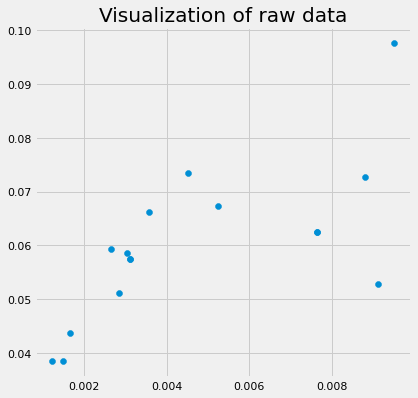

In [5]:
#plot data: https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a
#Modules
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import seaborn as sns
from sklearn.datasets.samples_generator import (make_blobs,
                                                make_circles,
                                                make_moons)
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

%matplotlib inline
sns.set_context('notebook')
plt.style.use('fivethirtyeight')
from warnings import filterwarnings
filterwarnings('ignore')

# Import the data
df = pd.read_csv('710.csv')#change the file here for cluster

# Plot the data
plt.figure(figsize=(6, 6))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1])
plt.xlabel('')
plt.ylabel('')
plt.title('Visualization of raw data');


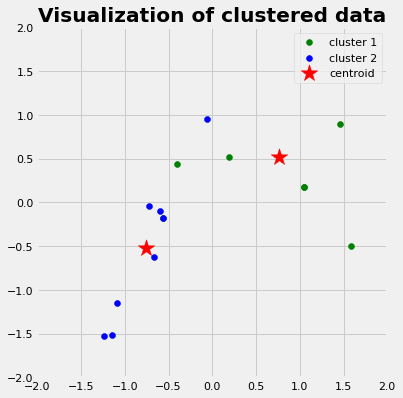

In [6]:
# Standardize the data
X_std = StandardScaler().fit_transform(df)

# Run local implementation of kmeans
km = Kmeans(n_clusters=2, max_iter=100)
km.fit(X_std)
centroids = km.centroids

# Plot the clustered data
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(X_std[km.labels == 0, 0], X_std[km.labels == 0, 1],
            c='green', label='cluster 1')
plt.scatter(X_std[km.labels == 1, 0], X_std[km.labels == 1, 1],
            c='blue', label='cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300,
            c='r', label='centroid')
plt.legend()
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('')
plt.ylabel('')
plt.title('Visualization of clustered data', fontweight='bold')
ax.set_aspect('equal');

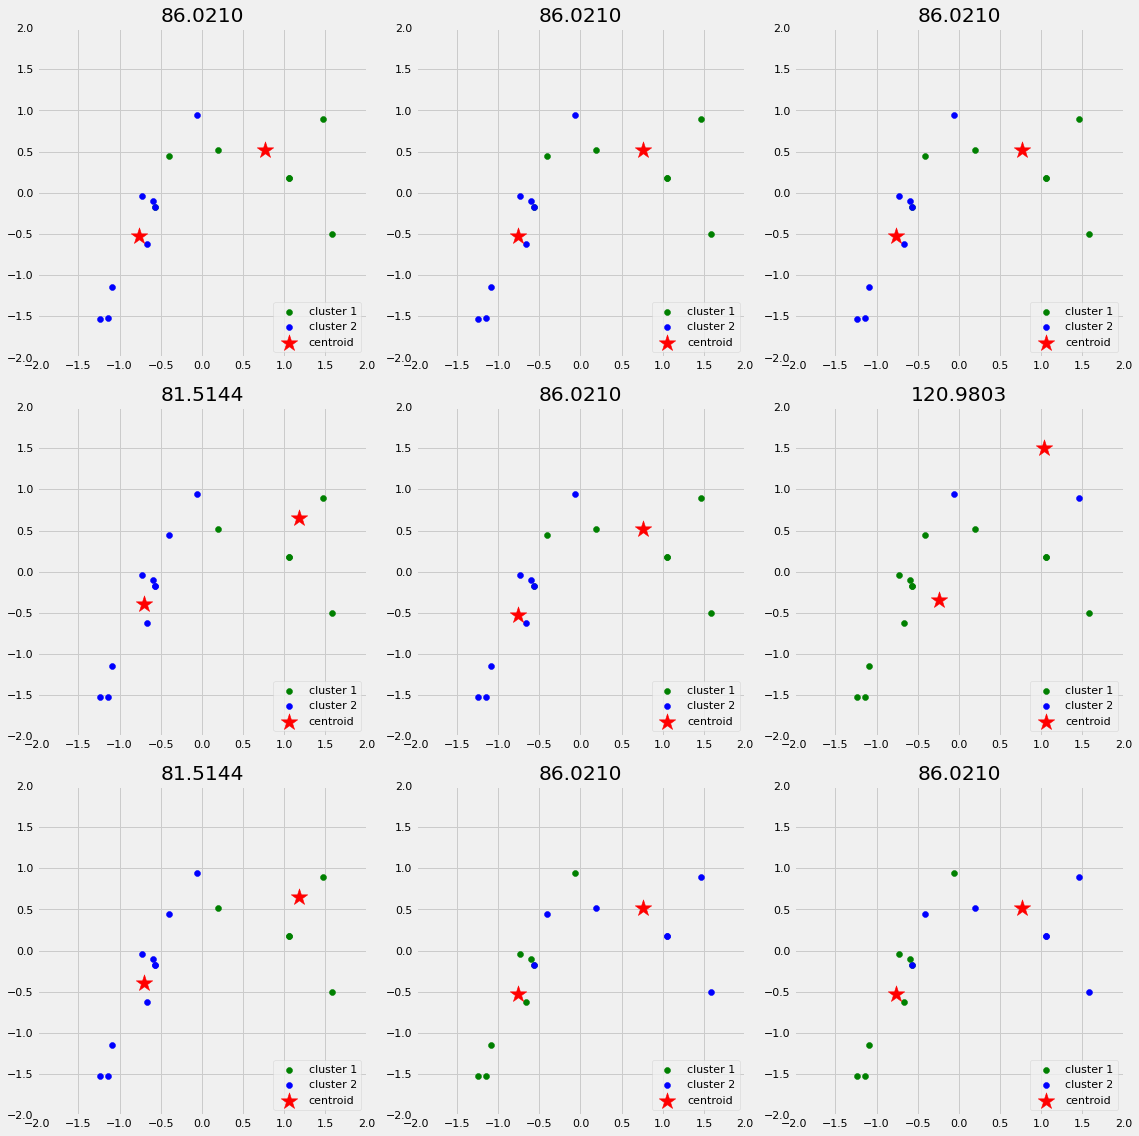

In [7]:

n_iter = 9
fig, ax = plt.subplots(3, 3, figsize=(16, 16))
ax = np.ravel(ax)
centers = []
for i in range(n_iter):
    # Run local implementation of kmeans
    km = Kmeans(n_clusters=2,
                max_iter=3,
                random_state=np.random.randint(0, 1000, size=1))
    km.fit(X_std)
    centroids = km.centroids
    centers.append(centroids)
    ax[i].scatter(X_std[km.labels == 0, 0], X_std[km.labels == 0, 1],
                  c='green', label='cluster 1')
    ax[i].scatter(X_std[km.labels == 1, 0], X_std[km.labels == 1, 1],
                  c='blue', label='cluster 2')
    ax[i].scatter(centroids[:, 0], centroids[:, 1],
                  c='r', marker='*', s=300, label='centroid')
    ax[i].set_xlim([-2, 2])
    ax[i].set_ylim([-2, 2])
    ax[i].legend(loc='lower right')
    ax[i].set_title(f'{km.error:.4f}')
    ax[i].set_aspect('equal')
plt.tight_layout();

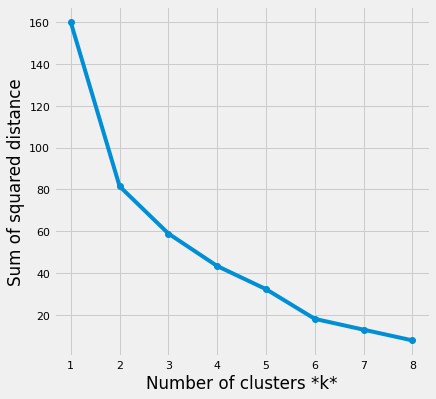

In [9]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 9))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_std)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

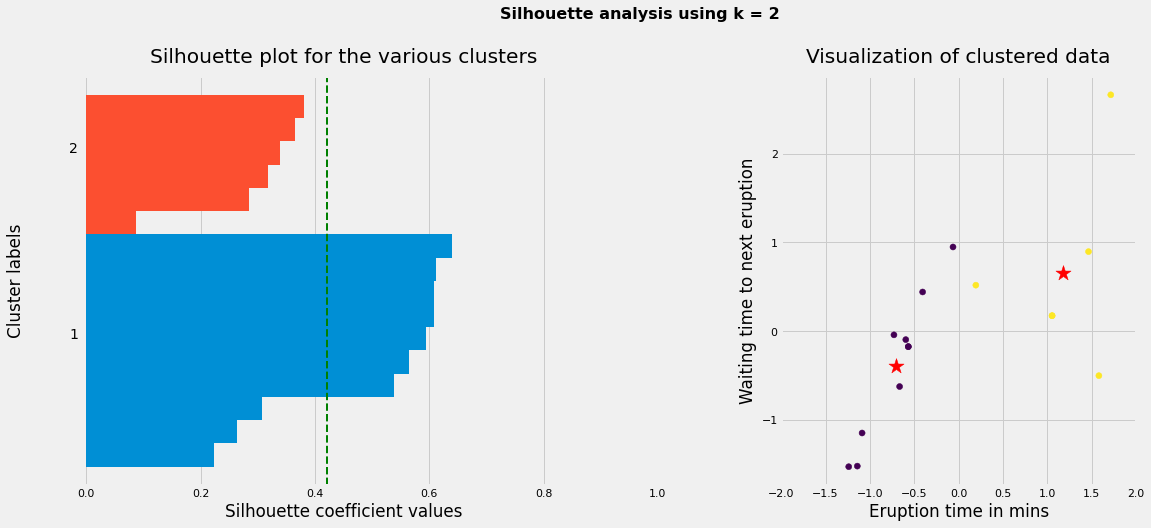

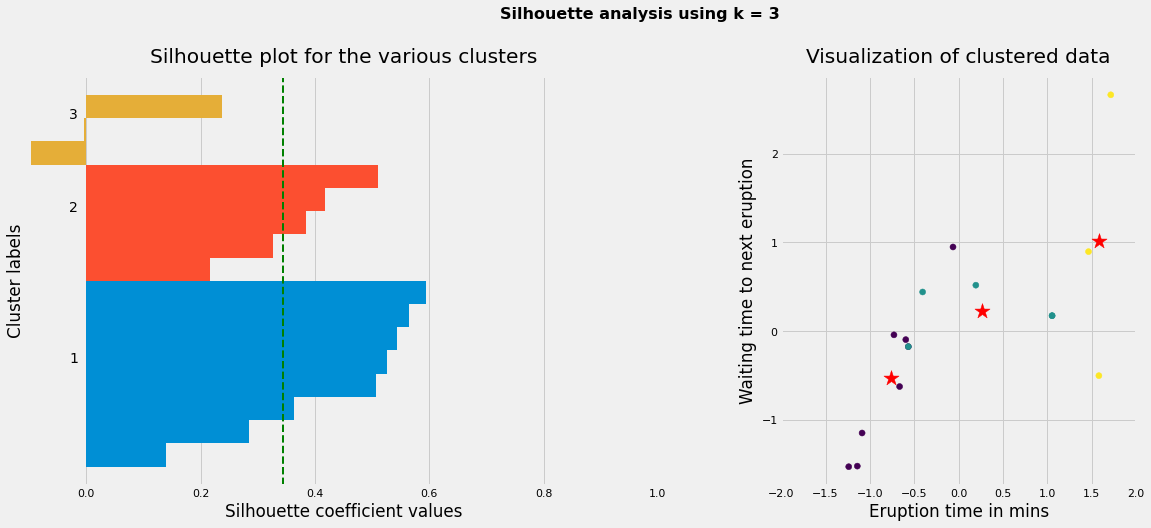

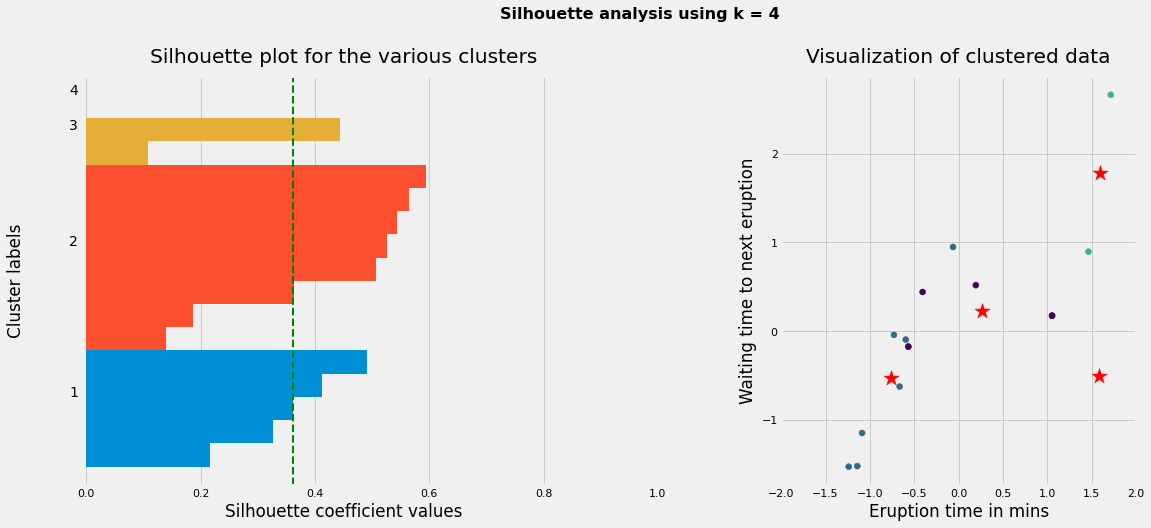

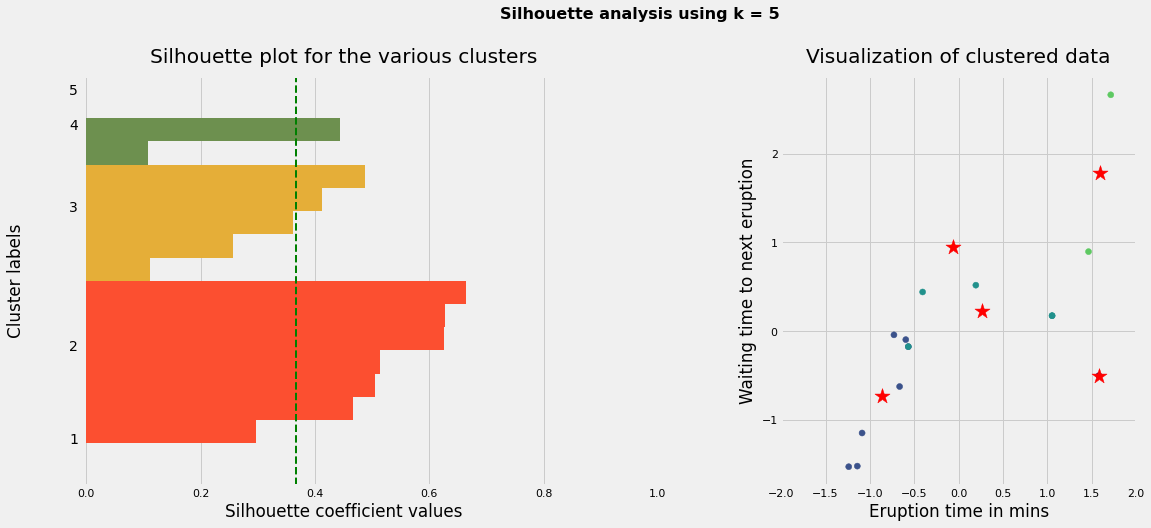

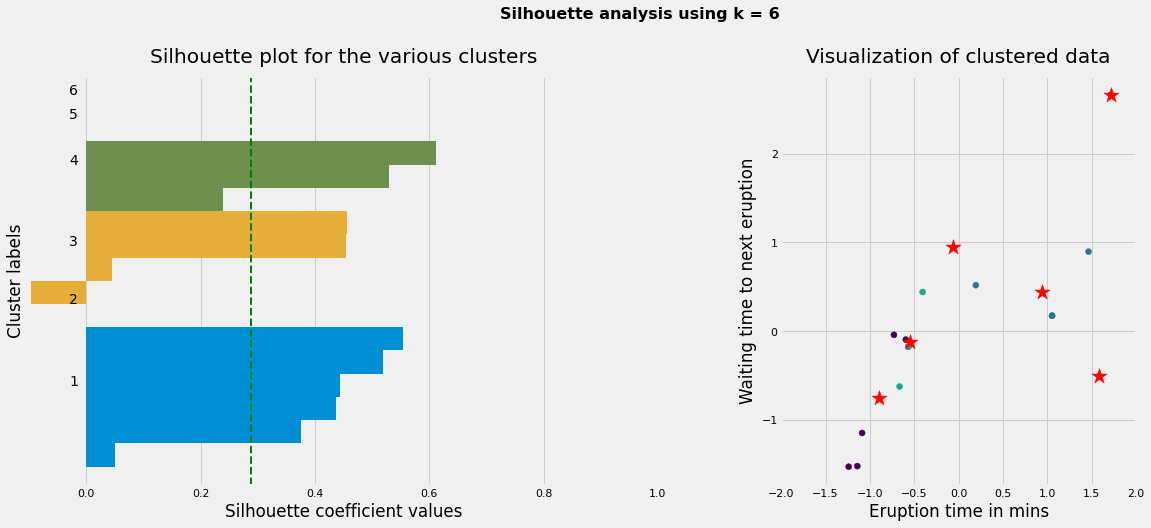

In [10]:
for i, k in enumerate([2, 3, 4, 5, 6]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X_std)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X_std, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(X_std[:, 0], X_std[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('Eruption time in mins')
    ax2.set_ylabel('Waiting time to next eruption')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

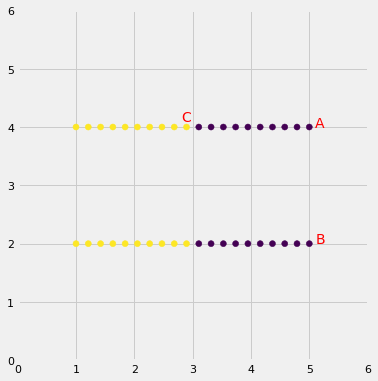

In [12]:
# Create horizantal data
X = np.tile(np.linspace(1, 5, 20), 2)
y = np.repeat(np.array([2, 4]), 20)
df = np.c_[X, y]

km = KMeans(n_clusters=2)
km.fit(df)
labels = km.predict(df)
centroids = km.cluster_centers_

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(X, y, c=labels)
plt.xlim([0, 6])
plt.ylim([0, 6])
plt.text(5.1, 4, 'A', color='red')
plt.text(5.1, 2, 'B', color='red')
plt.text(2.8, 4.1, 'C', color='red')
ax.set_aspect('equal')

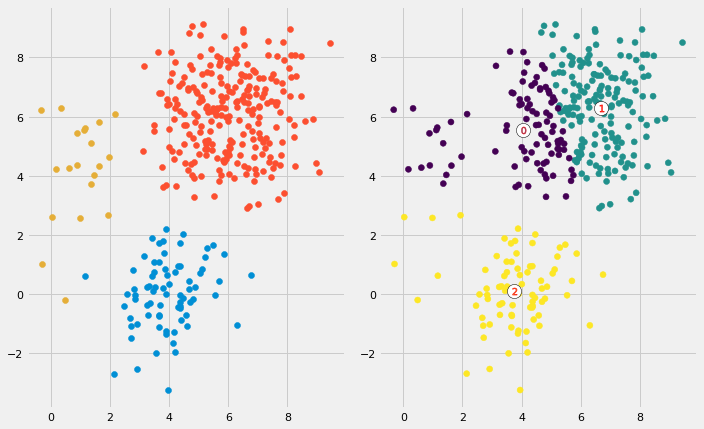

In [13]:
# Create data from three different multivariate distributions
X_1 = np.random.multivariate_normal(mean=[4, 0], cov=[[1, 0], [0, 1]], size=75)
X_2 = np.random.multivariate_normal(mean=[6, 6], cov=[[2, 0], [0, 2]], size=250)
X_3 = np.random.multivariate_normal(mean=[1, 5], cov=[[1, 0], [0, 2]], size=20)
df = np.concatenate([X_1, X_2, X_3])

# Run kmeans
km = KMeans(n_clusters=3)
km.fit(df)
labels = km.predict(df)
centroids = km.cluster_centers_

# Plot the data
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].scatter(X_1[:, 0], X_1[:, 1])
ax[0].scatter(X_2[:, 0], X_2[:, 1])
ax[0].scatter(X_3[:, 0], X_3[:, 1])
ax[0].set_aspect('equal')
ax[1].scatter(df[:, 0], df[:, 1], c=labels)
ax[1].scatter(centroids[:, 0], centroids[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
for i, c in enumerate(centroids):
    ax[1].scatter(c[0], c[1], marker='$%d$' % i, s=50, alpha=1, edgecolor='r')
ax[1].set_aspect('equal')
plt.tight_layout()

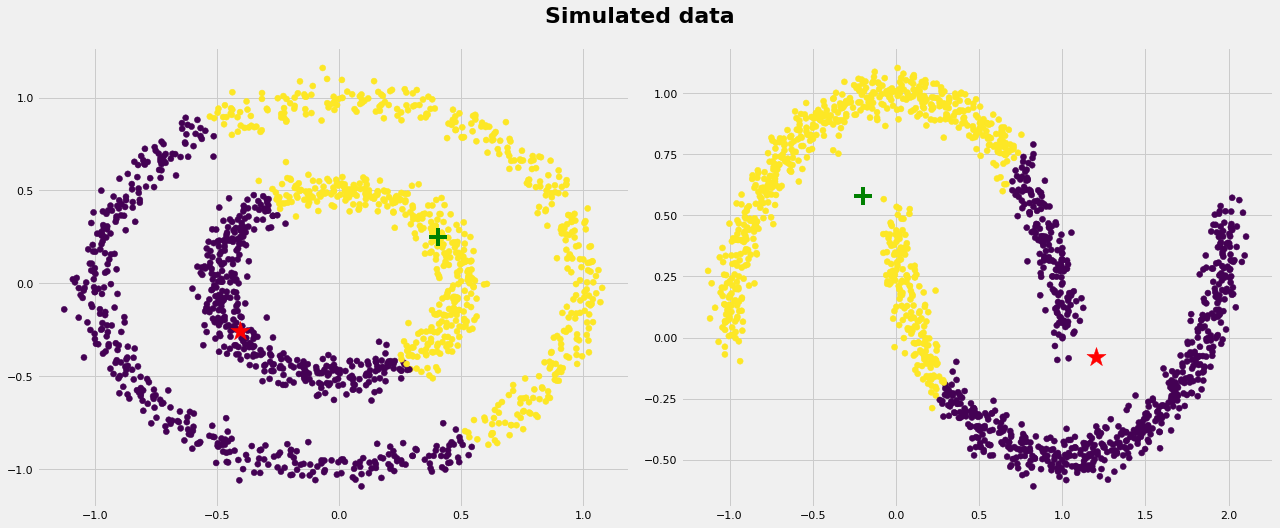

In [14]:
# Cricles
X1 = make_circles(factor=0.5, noise=0.05, n_samples=1500)

# Moons
X2 = make_moons(n_samples=1500, noise=0.05)

fig, ax = plt.subplots(1, 2)
for i, X in enumerate([X1, X2]):
    fig.set_size_inches(18, 7)
    km = KMeans(n_clusters=2)
    km.fit(X[0])
    labels = km.predict(X[0])
    centroids = km.cluster_centers_

    ax[i].scatter(X[0][:, 0], X[0][:, 1], c=labels)
    ax[i].scatter(centroids[0, 0], centroids[0, 1], marker='*', s=400, c='r')
    ax[i].scatter(centroids[1, 0], centroids[1, 1], marker='+', s=300, c='green')
plt.suptitle('Simulated data', y=1.05, fontsize=22, fontweight='semibold')
plt.tight_layout()

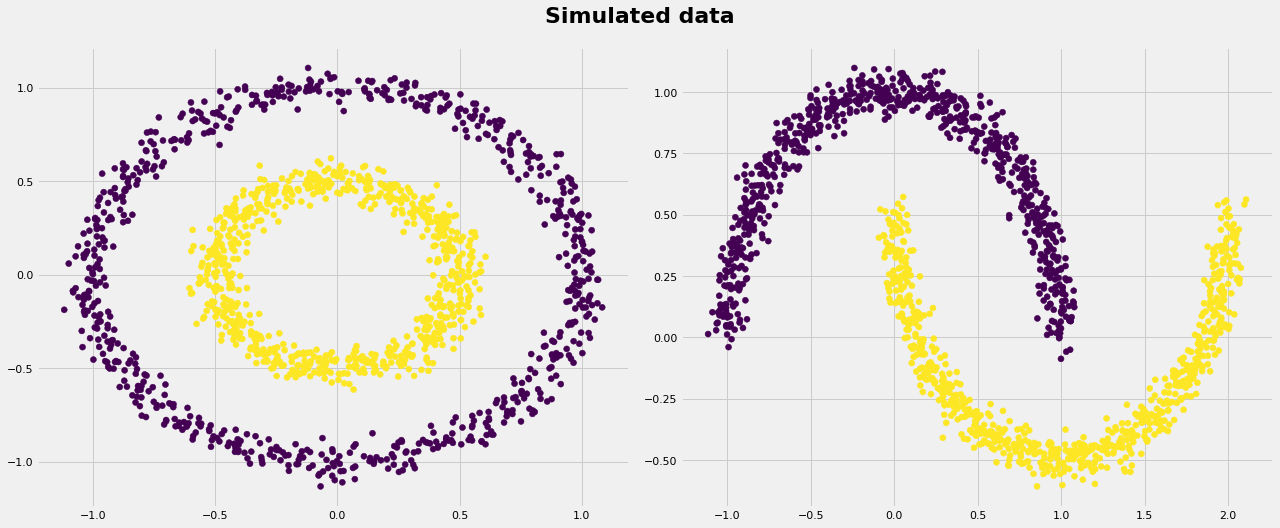

In [15]:
# Cricles
X1 = make_circles(factor=0.5, noise=0.05, n_samples=1500)

# Moons
X2 = make_moons(n_samples=1500, noise=0.05)

fig, ax = plt.subplots(1, 2)
for i, X in enumerate([X1, X2]):
    fig.set_size_inches(18, 7)
    sp = SpectralClustering(n_clusters=2, affinity='nearest_neighbors')
    sp.fit(X[0])
    labels = sp.labels_
    ax[i].scatter(X[0][:, 0], X[0][:, 1], c=labels)
plt.suptitle('Simulated data', y=1.05, fontsize=22, fontweight='semibold')
plt.tight_layout();

In [16]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_std)
kmeans.labels_

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1], dtype=int32)

In [ ]:
#array([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1], dtype=int32)